In [1]:
import xarray as xr 
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.ticker as mticker

In [2]:
from dask.distributed import Client

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [4]:
import numpy as np

In [5]:
client = Client(n_workers=4, threads_per_worker=2, memory_limit=8e9, ip="0.0.0.0")
client

/opt/conda/lib/python3.10/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42829 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://134.245.3.15:42829/status,
Dashboard: http://134.245.3.15:42829/status,Workers: 4
Total threads: 8,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://134.245.3.15:45355,Workers: 4
Dashboard: http://134.245.3.15:42829/status,Total threads: 8
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://134.245.3.15:40499,Total threads: 2
Dashboard: http://134.245.3.15:38083/status,Memory: 7.45 GiB
Nanny: tcp://134.245.3.15:37779,


In [6]:
data_path = '/gxfs_work1/geomar/smomw529/2022_north-sea_oysters/data/ocean/MetO-NWS-PHY-hi-CUR/'
data_filename = '2021/07/*.nc'

lat_top = 62.74
lat_bottom = 46
lon_left = -16
lon_right = 13

In [7]:
data_path = Path(data_path)
files = list(sorted((data_path).glob(data_filename)))

In [8]:
ds = xr.open_mfdataset(files, chunks={"lon": 958, "lat": 1240, "time": 365, "depth": 3})

In [9]:
ds

,Array,Chunk
Bytes,108.65 GiB,326.27 MiB
Shape,"(744, 33, 1240, 958)","(24, 3, 1240, 958)"
Count,713 Tasks,341 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,108.65 GiB,326.27 MiB
Shape,"(744, 33, 1240, 958)","(24, 3, 1240, 958)"
Count,713 Tasks,341 Chunks
Type,float32,numpy.ndarray


In [10]:
u = ds["uo"].sel(depth=slice(0, 10, None)).sel(time=slice('2021-07-15T00:00:00','2021-07-15T09:00:00'))
v = ds["vo"].sel(depth=slice(0, 10, None)).sel(time=slice('2021-07-15T00:00:00','2021-07-15T09:00:00'))

In [11]:
# wadden sea
u = u.sel(lon=slice(6.8, 8.2, None), lat=slice(53.5, 54, None))
v = v.sel(lon=slice(6.8, 8.2, None), lat=slice(53.5, 54, None))

In [12]:
vel = xr.combine_by_coords([u, v], compat='override', combine_attrs='drop_conflicts')

In [13]:
vel["vel"] = np.sqrt(vel.uo**2 + vel.vo**2)

In [14]:
vel = vel.compute()

In [15]:
vel

<xarray.Dataset>
Dimensions:  (time: 10, lat: 38, lon: 46, depth: 4)
Coordinates:
  * time     (time) datetime64[ns] 2021-07-15 ... 2021-07-15T09:00:00
  * lat      (lat) float32 53.5 53.51 53.53 53.54 ... 53.96 53.97 53.99 54.0
  * lon      (lon) float32 6.818 6.848 6.879 6.909 ... 8.091 8.121 8.152 8.182
  * depth    (depth) float32 0.0 3.0 5.0 10.0
Data variables:
    uo       (time, depth, lat, lon) float32 0.355 0.304 0.301 ... -0.235 -0.29
    vo       (time, depth, lat, lon) float32 0.045 0.033 -0.054 ... 0.177 0.166
    vel      (time, depth, lat, lon) float32 0.3578 0.3058 ... 0.2942 0.3341

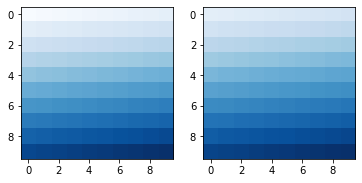

In [16]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

arr = np.linspace(0, 50, 100).reshape((10, 10))
fig, ax = plt.subplots(ncols=2)

cmap = plt.get_cmap('Blues')
new_cmap = truncate_colormap(cmap, 0.1, 1)
ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
plt.show()

In [17]:
plt.rcParams.update({'font.size': 34})

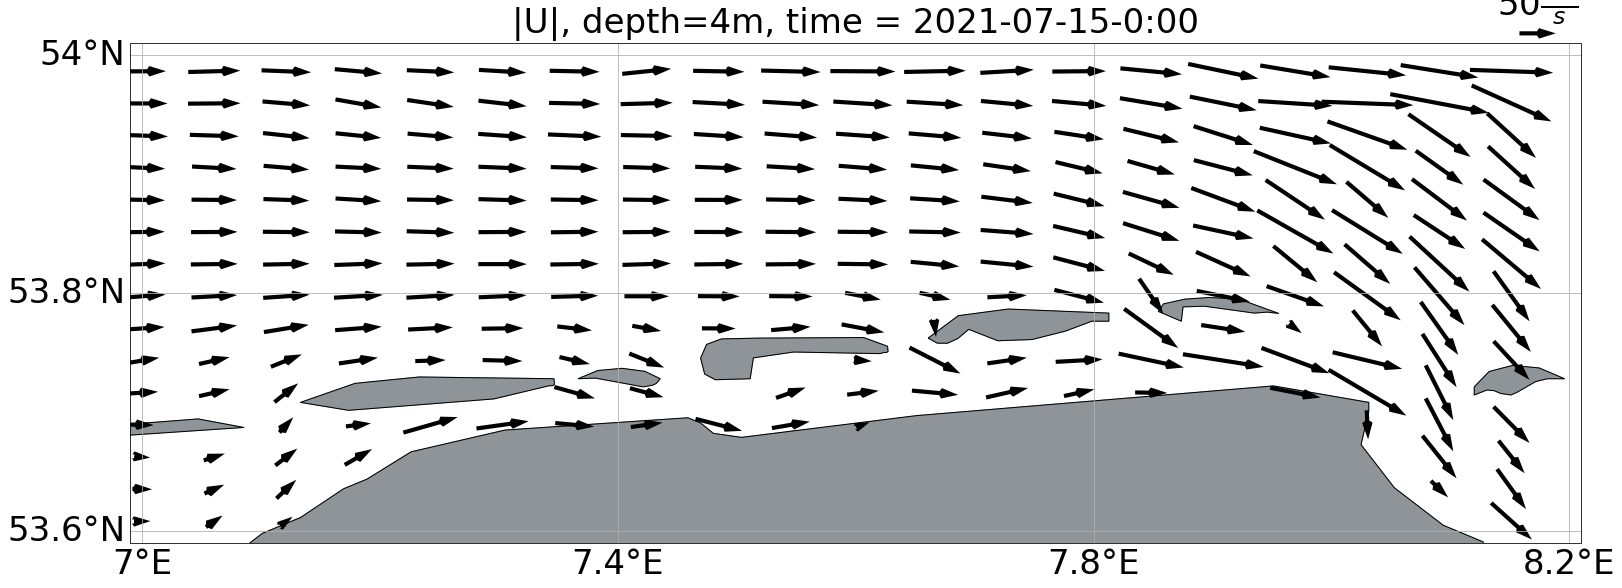

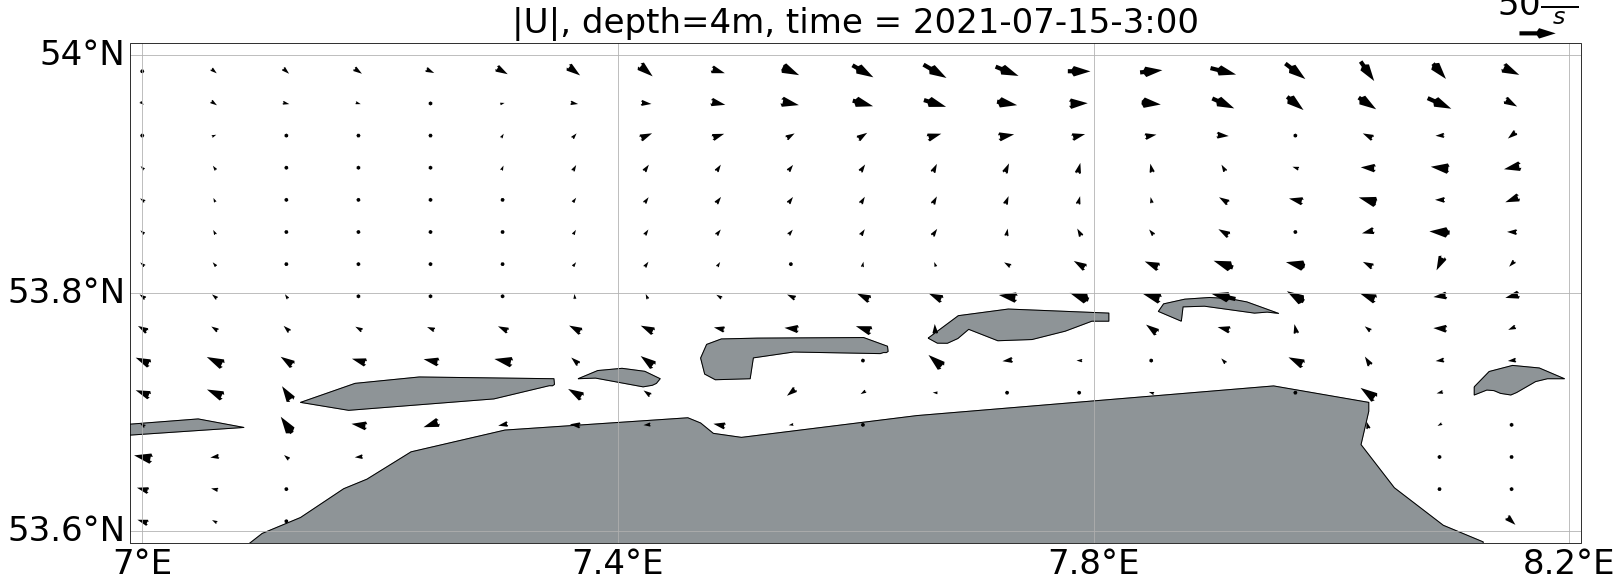

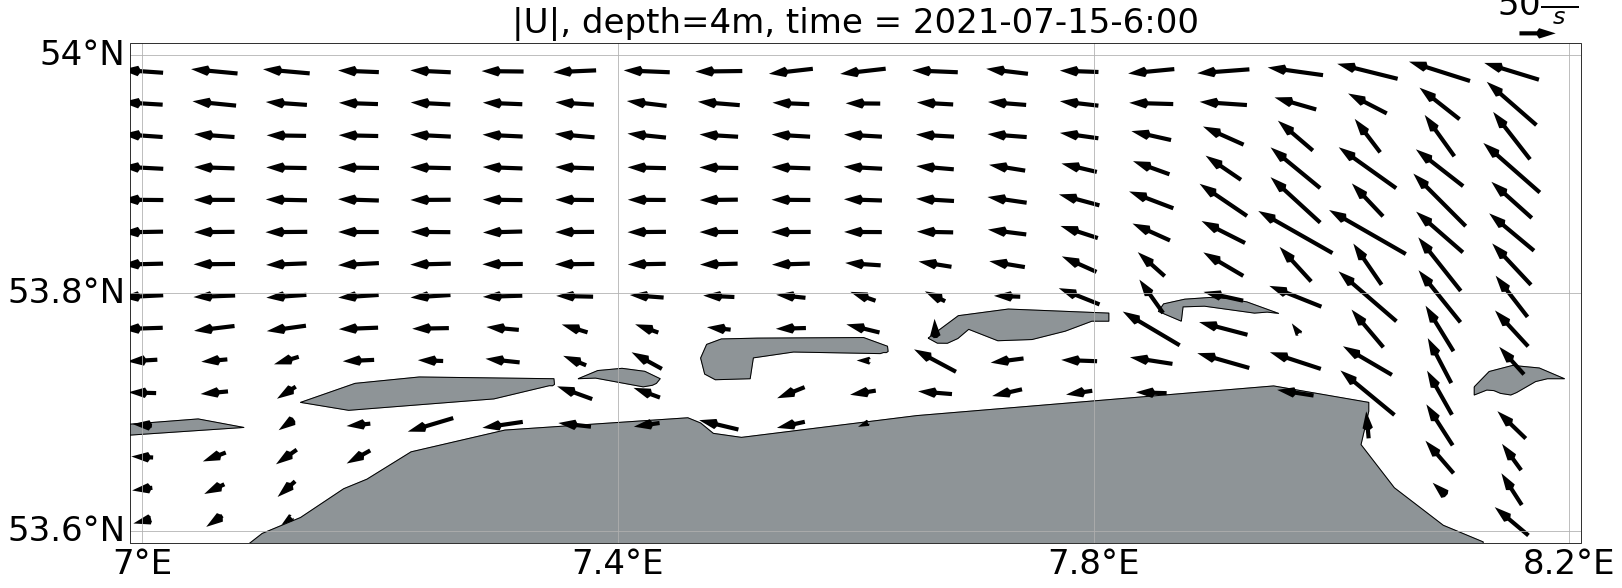

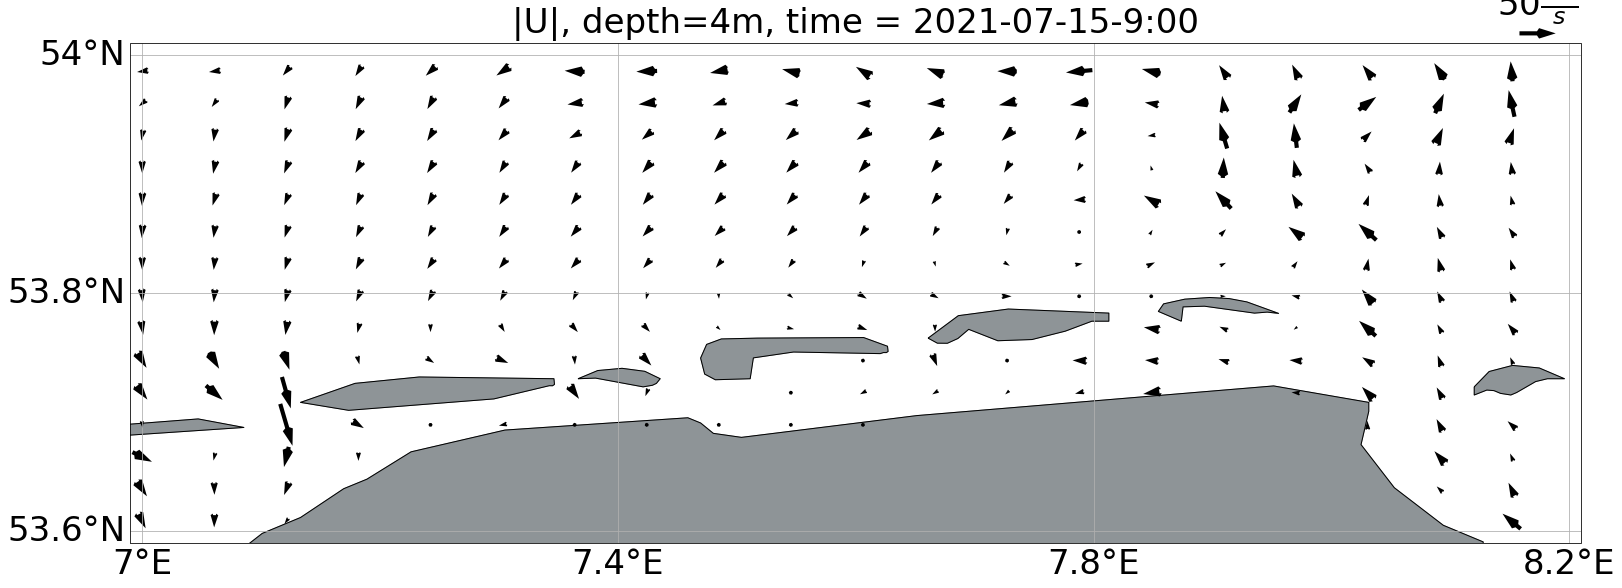

In [18]:
for i, depth in enumerate([4]):
    for j in [0,3,6,9]:
        fig, ax = plt.subplots(1, 1, sharex=True, sharey=True,
                               subplot_kw={"projection": ccrs.PlateCarree()},
                               figsize=(26, 12),
                              )
        ax.coastlines(resolution='10m')
        ax.add_feature(cf.BORDERS)
        ax.add_feature(cf.LAND, facecolor='#8e9497ff')#(138, 145, 149, 1.00)
      #  (vel["vel"]*100).isel(depth=i, time=j).plot(#.where(mask==1)
      #  ax=ax, transform=ccrs.PlateCarree(), x="lon", y="lat", levels=np.linspace(0, 200, 6),
      #  cmap=new_cmap, cbar_kwargs={"label": "cm/s"}, vmax=150
      #  )
        q = vel.where(vel["vel"] > 0).isel(depth=i, lon=slice(None, None, 2),
                                           lat=slice(None, None, 2), time=j).plot.quiver(
            ax=ax, transform=ccrs.PlateCarree(), x="lon", y="lat", u="uo", v="vo", scale=20, color="black",
            add_guide=True, linewidths=0.1, headwidth=2.5, headlength= 4
            )
        ax.quiverkey(q, 0.97, 1.02, 0.5, r'$50 \frac{cm}{s}$', coordinates='axes')
        ax.set_extent([6.99, 8.21, 53.59, 54.01], crs=ccrs.PlateCarree())
        gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=["bottom", "left"], xlabel_style={"size": 34}, ylabel_style={"size": 34});

        ax.set_title(f"|U|, depth={depth}m, time = 2021-07-15-{j}:00".format(depth=depth), size=34)
        gl.xlocator=mticker.FixedLocator([7,7.4,7.8,8.2])
        gl.ylocator=mticker.FixedLocator([53.6,53.8,54]);
        fig
    
        plt.savefig(f"wadden-sea_tides_{depth}m_2021-07-15-{j}:00.svg".format(depth=depth), dpi=300)